# **Para instalar todas as bibliotecas de uma vez, basta rodar no terminal o comando:** <br>  pip install -r requirements.txt

In [ ]:
import tweepy as tw
import pandas as pd
import configparser as cp
from textblob import TextBlob
import re
import unicodedata
import string
import json
import numpy as np
import nltk
import sklearn 
import seaborn as sb
import matplotlib.pyplot as plt
from colorama import Fore,Style,Back
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#ALGORITMOS SELECIONADOS ATÉ O MOMENTO
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
#-----------------------------------------
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

np.random.seed(1914)  ## IMPORTANTE PARA TER OS MESMOS RESULTADOS NA HORA QUE RODAR. 



## mudar thema do notebook jt -t solarizedd -T -N -kl
# Resetar thema jt -r
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

In [ ]:
# nltk.download()

In [ ]:
# config = cp.ConfigParser()
# config.read('config.ini')
# api_key = config['twitter_credenciais']['api_key']
# api_key_secret = config['twitter_credenciais']['api_key_secret']
# access_token = config['twitter_credenciais']['access_token']
# access_token_secret = config['twitter_credenciais']['access_token_secret']

In [ ]:
# auth = tw.OAuthHandler(api_key,api_key_secret)
# auth.set_access_token(access_token,access_token_secret)
# api = tw.API(auth)

In [ ]:
df = pd.read_csv('dataset_depressao.csv')
filter = (df['id_tweet'] == 3696)
df.loc[filter,'psiquico'] = 0 

In [ ]:
df.rename(columns = {'label':'target'}, inplace = True)

In [ ]:
display(df)

In [ ]:
# df['data_postagem'] = pd.to_datetime(df['dh_tweet']).dt.date
# df['hora_postagem'] = pd.to_datetime(df['dh_tweet']).dt.time

In [ ]:
display(df)

In [ ]:
## HISTOGRAMA COM FREQUENCIA DAS CLASSES NA BASE
x = df['target']
plt.title('FREQUENCIA DAS CLASSES NA BASE')
plt.xlabel("Classes (0=Nenhum, 1=Fisiológico, 2=Comportamental, \n 3=Psíquico)")
plt.hist(x, 4, rwidth=0.9, color='red', alpha=0.7, edgecolor='black') ## x corresponde a coluna do dataset que armazena as classes (label/target no caso)
# 4 corresponde ao numero de classes, e rwidth ao tamanho das barras


## Confirmando os valores do histograma
classe = [0,1,2,3]
for i in range(len(classe)):
    classe_mensagem = "{}{}{}".format("total da classe ", i, " é: ") 
    print(Fore.MAGENTA + "{}{}".format(classe_mensagem, len(df[df["target"]==i])))

In [ ]:
depdf = sb.countplot(df)

In [ ]:
sb.countplot(y=df['fisiologico'], hue=df['fisiologico'],data=df)

In [ ]:
sb.countplot(y=df['psiquico'], hue=df['psiquico'],data=df)

In [ ]:
sb.countplot(y=df['comportamental'], hue=df['comportamental'],data=df)

In [ ]:
def limpar_tweets(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)# Remove mencoes
    text = re.sub(r'@[A-Za-z0-9]_+', '', text)# Remove mencoes
    text = re.sub(r'@_[A-Za-z0-9]+', '', text)# Remove mencoes
    text = re.sub(r'@_[A-Za-z0-9]_+', '', text)# Remove mencoes
    text = re.sub(r'#','', text) # Remove simbolo de hashtags
    text = re.sub(r'RT[\s]+','',text) # Remove Retweets
    text = re.sub(r'https?:/\/\S+','',text) # Remove URLS

    regrex_pattern = re.compile(pattern = "["   #Remove todos os emojis
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', text)
    return text

In [ ]:
df['tweets'] = df['ds_tweet'].apply(limpar_tweets)
df.head()
len(df)

In [ ]:
df = df.drop(df[df['tweets'] == ''].index)
df = df.dropna(axis=0)
len(df.index)

In [ ]:
filter = (df['id_tweet'] == 8369)
teste = df.loc[filter,'tweets']  
print(teste)

df['tweets'] = df['tweets'].str.lower()  ## padroniza os tweets transformando de uppercase para lowercase

## Verificando se os tweets estao padronizados em lowercase
filter = (df['id_tweet'] == 8369)
teste = df.loc[filter,'tweets']  
print(teste)

In [ ]:
stop = stopwords.words("portuguese")

print(stop)

In [ ]:
## removendo os stopwords
df["tweets"] = df["tweets"].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [ ]:
display(df["tweets"])

In [ ]:
## remoção de acentos
def remove_combining_fluent(text):
    normalized = unicodedata.normalize('NFD', text)
    return ''.join(
        [l for l in normalized if not unicodedata.combining(l)]
    ).casefold()

In [ ]:
## remoção de pontuacoes
def remove_pontuacoes(text):
    normalized = unicodedata.normalize('NFD', text)
    return ''.join(
        c for c in normalized if c not in string.punctuation)

In [ ]:
df['tweets'] = df['tweets'].apply(remove_combining_fluent)

In [ ]:
df['tweets'] = df['tweets'].apply(remove_pontuacoes)

In [93]:
df['tweets'] = df['tweets'].apply(remove_combining_fluent)

In [94]:
df['tweets'] = df['tweets'].apply(remove_pontuacoes)

In [95]:
display(df)

,id_tweet,ds_tweet,fisiologico,psiquico,comportamental,target,validado_espec,dh_tweet,tweets
0,3696,dormi o dia inteiro tinha horas w meu desperta...,1,0,0,1,1,2019-10-09 02:32:41.000000,dormi dia inteiro horas w despertafor tocava a...
1,3885,já entendi que eu não sou importante tá bom,0,1,0,3,1,2019-10-12 12:15:04.000000,entendi importante ta bom
2,3888,chorando pq não sou importante pra ngm 👍🏿 http...,0,1,0,3,1,2019-10-11 23:56:04.000000,chorando pq importante pra ngm
3,3889,Sinto sempre que nao sou importante para certa...,0,1,0,3,1,2019-10-12 14:43:38.000000,sinto sempre nao importante certas pessoas man...
4,8369,Tô indo pra escola com a força do ódio,0,0,0,0,1,2019-10-11 12:10:22.000000,to indo pra escola forca odio
...,...,...,...,...,...,...,...,...,...
4045,10629,@LUCAztec como ousa,0,0,0,0,0,2019-11-01 00:58:30.000000,ousa
4046,10630,@tatastew aí amiga mas pelo menos ele lembra K...,0,0,0,0,0,2019-10-31 17:37:21.000000,ai amiga menos lembra kkkkkkk lucas noia carai...
4047,10631,"eu só quero chegar em casa, tomar um banho e m...",0,0,0,0,0,2019-10-31 16:07:31.000000,quero chegar casa tomar banho enfiar cama
4048,10632,vou ter que dar um menos no café porque se pá ...,0,0,0,0,0,2019-11-11 11:42:42.000000,vou ter dar menos cafe porque pa quantidade an...


In [96]:
# stemmer = PorterStemmer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    lemma_words = [lemmatizer.lemmatize(word) for word in w_tokenizer.tokenize(text)]
    return " ".join(lemma_words)

# def stemming_text(text):
#     stemming_words = [stemmer.stem(word) for word in nltk.word_tokenize(text)]
#     return " ".join(stemming_words)


In [97]:
df["tweets"] = df["tweets"].apply(lemmatize_text) ## para testar o stemming, basta trocar o nome da funcao no parametro.
# df

In [98]:
display(df)

,id_tweet,ds_tweet,fisiologico,psiquico,comportamental,target,validado_espec,dh_tweet,tweets
0,3696,dormi o dia inteiro tinha horas w meu desperta...,1,0,0,1,1,2019-10-09 02:32:41.000000,dormi dia inteiro horas w despertafor tocava a...
1,3885,já entendi que eu não sou importante tá bom,0,1,0,3,1,2019-10-12 12:15:04.000000,entendi importante ta bom
2,3888,chorando pq não sou importante pra ngm 👍🏿 http...,0,1,0,3,1,2019-10-11 23:56:04.000000,chorando pq importante pra ngm
3,3889,Sinto sempre que nao sou importante para certa...,0,1,0,3,1,2019-10-12 14:43:38.000000,sinto sempre nao importante certas pessoas man...
4,8369,Tô indo pra escola com a força do ódio,0,0,0,0,1,2019-10-11 12:10:22.000000,to indo pra escola forca odio
...,...,...,...,...,...,...,...,...,...
4045,10629,@LUCAztec como ousa,0,0,0,0,0,2019-11-01 00:58:30.000000,ousa
4046,10630,@tatastew aí amiga mas pelo menos ele lembra K...,0,0,0,0,0,2019-10-31 17:37:21.000000,ai amiga menos lembra kkkkkkk lucas noia carai...
4047,10631,"eu só quero chegar em casa, tomar um banho e m...",0,0,0,0,0,2019-10-31 16:07:31.000000,quero chegar casa tomar banho enfiar cama
4048,10632,vou ter que dar um menos no café porque se pá ...,0,0,0,0,0,2019-11-11 11:42:42.000000,vou ter dar menos cafe porque pa quantidade an...


In [99]:
# ALGORITMO BAG OF WORDS
BagOfWords = CountVectorizer()
BagOfWords.fit_transform(df['tweets'])
BagOfWords.get_feature_names_out()
BagOfWords_result = BagOfWords.transform(df['tweets'])


In [100]:
display(BagOfWords_result.toarray())

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [101]:
#ALGORITMO TFIDF

tfidf_vec = TfidfVectorizer(use_idf=True)
tfidf_vec.fit(df['tweets'])
tfidf_result = tfidf_vec.transform(df['tweets'])

In [102]:
pd.DataFrame(tfidf_result.toarray()).to_csv('tfidf_result.csv')

In [103]:
#SEPARA OS CONJUNTOS DE TREINAMENTO E TESTE
X = tfidf_result  #Caso necessite usar outro metodo apenas trocar essa variavel por tfidf_result ou BagOfWords_result
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

MATRIZ DE CONFUSAO
---------------------- 

[[448  18   7  72]
 [ 12  70   1   7]
 [  3   3  68  20]
 [ 47   6  11 220]]
---------------------- 

ACURACIDADE
---------------------- 

0.7956564659427443
---------------------- 


 
  RELATORIO COM MAIS INFORMACOES

 
 
 
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       545
           1       0.72      0.78      0.75        90
           2       0.78      0.72      0.75        94
           3       0.69      0.77      0.73       284

    accuracy                           0.80      1013
   macro avg       0.77      0.77      0.77      1013
weighted avg       0.80      0.80      0.80      1013

F1 Score :  0.7697545813473361
Precision Score :  0.7678363062252985
Recall Score :  0.7744620672611808


<AxesSubplot: >

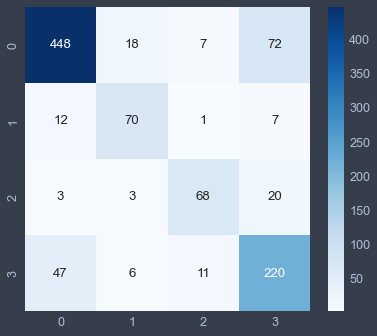

In [104]:
### ------------------------ TESTE COM ARVORE DE DECISÃO ------------------------------------------------

clf = DecisionTreeClassifier()  ## Instancia o objeto do referido algoritmo. Cria o Modelo.

clf.fit(X_train, y_train)  ## apresenta os dados x, y ao modelo

y_pred = clf.predict(X_test) ## Efetua as predições.

y_pred_prob = clf.predict_proba(X_test)

#Acuracidade


print(Style.BRIGHT + Fore.RED + "MATRIZ DE CONFUSAO" + Style.RESET_ALL)
print("---------------------- \n")
print(confusion_matrix(y_test, y_pred))
print("---------------------- \n")    

acuracidade_ar = accuracy_score(y_test, y_pred)
print(Style.BRIGHT + Fore.RED + "ACURACIDADE" + Style.RESET_ALL)
print("---------------------- \n")
print(acuracidade_ar)
print("---------------------- \n")    
# F1-SCORE

# f1 = f1_score(y_test, y_pred,pos_label='positive', average='micro')
# print(f1)

print(Fore.BLUE +  "\n \n  RELATORIO COM MAIS INFORMACOES")
print("\n \n \n ")

f1_score_ar = f1_score(y_test, y_pred, average="macro")
precision_score_ar = precision_score(y_test, y_pred,average="macro")
recall_score_ar = recall_score(y_test, y_pred, average="macro")

print(classification_report(y_test, y_pred))
print("F1 Score : ",f1_score_ar)##Average macro calcula uma média aritmetica entre todos os  f1-scores das classes
print("Precision Score : ",precision_score_ar)
print("Recall Score : ",recall_score_ar)




sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')

### ------------------------------------------------------------------------------------------------




0.848054935235953

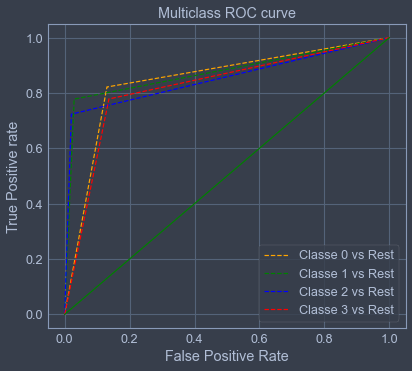

In [105]:
fpr = {}
tpr = {}
thresh ={}

n_class = [0,1,2,3]

for i in range(len(n_class)):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_prob[:,i], pos_label=i)
    
    
# plotting  One vs ALL   
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Classe 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Classe 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Classe 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Classe 3 vs Rest')
sb.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = None)
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

roc_auc_score(y_test, y_pred_prob, labels = n_class, multi_class = 'ovr', average = 'macro')

###### UTILIZAÇÃO DAS FUNÇÕES CRIADAS POR: [Vinícius Trevisan](https://github.com/vinyluis/Articles/tree/main/ROC%20Curve%20and%20ROC%20AUC)

###### Artigos utilizados para estudo do ROC AUC:<br> <br> [Interpreting ROC Curve and ROC AUC for Classification Evaluation](https://towardsdatascience.com/interpreting-roc-curve-and-roc-auc-for-classification-evaluation-28ec3983f077) <br>
[Multiclass classification evaluation with ROC Curves and ROC AUC](https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a)

In [106]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [107]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [108]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sb.scatterplot(x = fpr, y = tpr, ax = ax)
    sb.lineplot(x = fpr, y = tpr, ax = ax)
    sb.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [109]:
classes = [0,1,2,3]

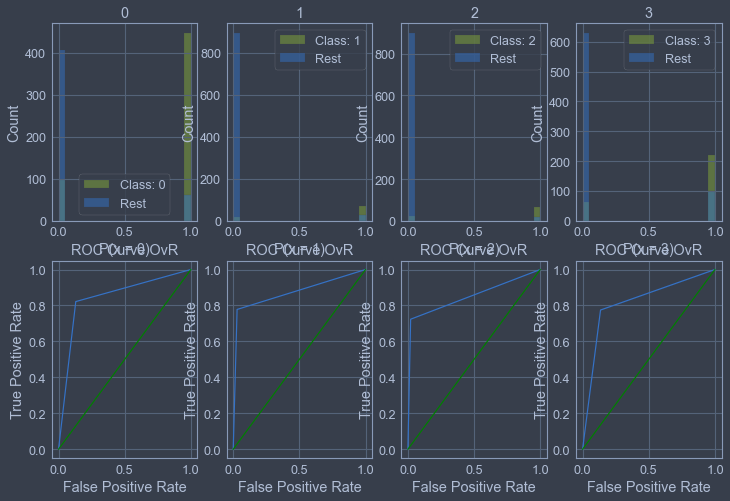

In [110]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    column_names = ["class", "prob"]
    df_aux = pd.DataFrame(columns = column_names)
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_pred_prob[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 4, i+1)
    sb.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 4, i+5)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

In [111]:
# Exibe a metrica ROC AUC para cada classe
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

0 ROC AUC OvR: 0.8456
1 ROC AUC OvR: 0.8743
2 ROC AUC OvR: 0.8514
3 ROC AUC OvR: 0.8209
average ROC AUC OvR: 0.8481


In [112]:
# Comparacao do resultado acima com a funcao do sklearn

roc_auc_score(y_test, y_pred_prob, labels = classes, multi_class = 'ovr', average = 'macro')

0.848054935235953

In [113]:
classes_combinations = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        classes_combinations.append([class_list[i], class_list[j]])
        classes_combinations.append([class_list[j], class_list[i]])
classes_combinations

[[0, 1],
 [1, 0],
 [0, 2],
 [2, 0],
 [0, 3],
 [3, 0],
 [1, 2],
 [2, 1],
 [1, 3],
 [3, 1],
 [2, 3],
 [3, 2]]

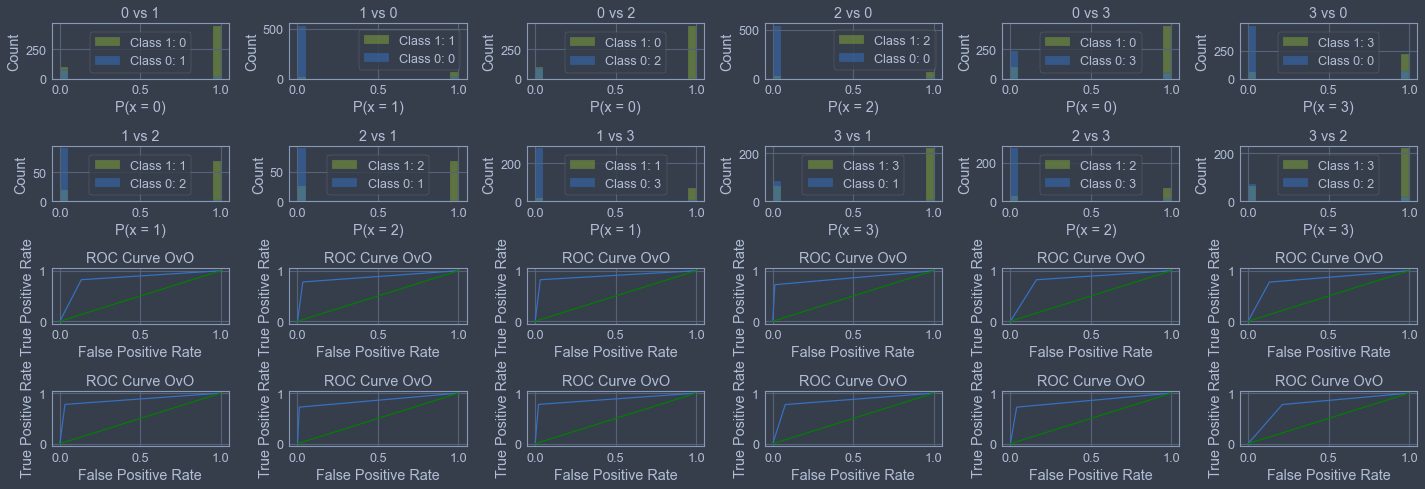

In [114]:
# Plots the Probability Distributions and the ROC Curves One vs ONe
plt.figure(figsize = (20, 7))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}

for i in range(len(classes_combinations)):
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = str(c1) + " vs " + str(c2)
    
    # Prepares an auxiliar dataframe to help with the plots
    column_names = ["class", "prob"]
    df_aux = pd.DataFrame(columns = column_names)
    df_aux['class'] = y_test
    df_aux['prob'] = y_pred_prob[:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(4, 6, i+1)
    sb.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(title)
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(4, 6, i+13)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvO")
    
    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()

In [115]:
# Exibe a metrica ROC AUC para cada classe
avg_roc_auc = 0
i = 0
for k in roc_auc_ovo:
    avg_roc_auc += roc_auc_ovo[k]
    i += 1
    print(f"{k} ROC AUC OvO: {roc_auc_ovo[k]:.4f}")
print(f"average ROC AUC OvO: {avg_roc_auc/i:.4f}")

0 vs 1 ROC AUC OvO: 0.8443
1 vs 0 ROC AUC OvO: 0.8724
0 vs 2 ROC AUC OvO: 0.8951
2 vs 0 ROC AUC OvO: 0.8553
0 vs 3 ROC AUC OvO: 0.8297
3 vs 0 ROC AUC OvO: 0.8228
1 vs 2 ROC AUC OvO: 0.8729
2 vs 1 ROC AUC OvO: 0.8561
1 vs 3 ROC AUC OvO: 0.8783
3 vs 1 ROC AUC OvO: 0.8501
2 vs 3 ROC AUC OvO: 0.8423
3 vs 2 ROC AUC OvO: 0.7823
average ROC AUC OvO: 0.8501


In [116]:
# Comparacao do resultado acima com a funcao do sklearn
roc_auc_score(y_test, y_pred_prob, labels = classes, multi_class = 'ovo', average = 'macro')

0.8501401112318753

MATRIZ DE CONFUSAO
---------------------- 

[[487  14   4  40]
 [ 13  70   0   7]
 [  8   2  70  14]
 [ 60   1   8 215]]
---------------------- 

ACURACIDADE
---------------------- 

0.8311944718657454
---------------------- 


 
  RELATORIO COM MAIS INFORMACOES

 
 
 
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       545
           1       0.80      0.78      0.79        90
           2       0.85      0.74      0.80        94
           3       0.78      0.76      0.77       284

    accuracy                           0.83      1013
   macro avg       0.82      0.79      0.81      1013
weighted avg       0.83      0.83      0.83      1013

F1 Score :  0.8073461123409157
Precision Score :  0.8236590277945878
Recall Score :  0.7932697160035276


<AxesSubplot: >

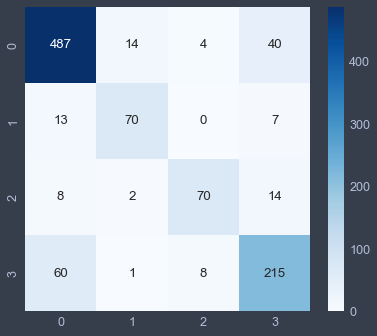

In [117]:
### TESTE COM ENSEMBLE RANDOM FOREST

rnd_mdl = RandomForestClassifier()
rnd_mdl.fit(X_train, y_train)


y_pred = rnd_mdl.predict(X_test)

#Acuracidade


print(Style.BRIGHT + Fore.RED + "MATRIZ DE CONFUSAO" + Style.RESET_ALL)
print("---------------------- \n")
print(confusion_matrix(y_test, y_pred))
print("---------------------- \n")    

acuracidade_rf = accuracy_score(y_test, y_pred)
print(Style.BRIGHT + Fore.RED + "ACURACIDADE" + Style.RESET_ALL)
print("---------------------- \n")
print(acuracidade_rf)
print("---------------------- \n")    


print(Fore.BLUE +  "\n \n  RELATORIO COM MAIS INFORMACOES")
print("\n \n \n ")

f1_score_rf = f1_score(y_test, y_pred, average="macro")
precision_score_rf = precision_score(y_test, y_pred, average="macro")
recall_score_rf = recall_score(y_test, y_pred,average="macro")

print(classification_report(y_test, y_pred))
print("F1 Score : ",f1_score_rf)
print("Precision Score : ",precision_score_rf)
print("Recall Score : ",recall_score_rf)



sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')

### ------------------------------------------------------------------------------------------------

MATRIZ DE CONFUSAO
---------------------- 

[[542  31   9  72]
 [ 33  70   0   5]
 [ 28   5  66  14]
 [108   7  10 215]]
---------------------- 

ACURACIDADE
---------------------- 

0.7349794238683127
---------------------- 


 
  RELATORIO COM MAIS INFORMACOES

 
 
 
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       654
           1       0.62      0.65      0.63       108
           2       0.78      0.58      0.67       113
           3       0.70      0.63      0.67       340

    accuracy                           0.73      1215
   macro avg       0.72      0.67      0.69      1215
weighted avg       0.73      0.73      0.73      1215

F1 Score :  0.6899811746560971
Precision Score :  0.7152151510692026
Recall Score :  0.6733295157887066


<AxesSubplot: >

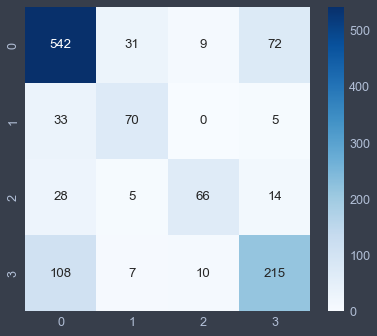

In [118]:
# TESTE COM KNN
knn = KNeighborsClassifier(3)

X = BagOfWords_result
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)




#Acuracidade


print(Style.BRIGHT + Fore.RED + "MATRIZ DE CONFUSAO" + Style.RESET_ALL)
print("---------------------- \n")
print(confusion_matrix(y_test, y_pred))
print("---------------------- \n")    

acuracidade_knn = accuracy_score(y_test, y_pred)
print(Style.BRIGHT + Fore.RED + "ACURACIDADE" + Style.RESET_ALL)
print("---------------------- \n")
print(acuracidade_knn)
print("---------------------- \n")    


print(Fore.BLUE +  "\n \n  RELATORIO COM MAIS INFORMACOES")
print("\n \n \n ")

f1_score_knn = f1_score(y_test, y_pred, average="macro")
precision_score_knn = precision_score(y_test, y_pred,average="macro")
recall_score_knn = recall_score(y_test, y_pred, 
                                           average="macro")

print(classification_report(y_test, y_pred))
print("F1 Score : ",f1_score_knn)
print("Precision Score : ",precision_score_knn)
print("Recall Score : ",recall_score_knn)


sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')

### ------------------------------------------------------------------------------------------------

In [119]:
training_accuracy = []
test_accuracy = []
neighbors = range(1,11)

for num_k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = num_k)
    knn.fit(X_train, y_train)
    training_accuracy.append(knn.score(X_train,y_train))
    test_accuracy.append(knn.score(X_test,y_test))

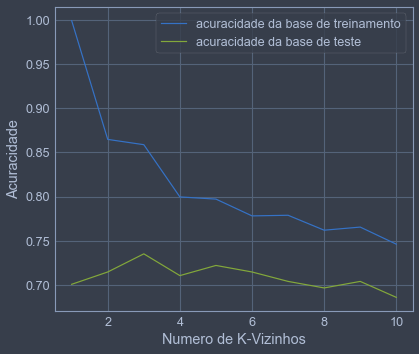

In [120]:
# PLOTA OS NIVEIS DE ACURACIDADE CALCULADOS POR K
plt.plot(neighbors,training_accuracy,label='acuracidade da base de treinamento')
plt.plot(neighbors,test_accuracy,label='acuracidade da base de teste')
plt.xlabel("Numero de K-Vizinhos")
plt.ylabel("Acuracidade")
plt.legend()
plt.savefig('k-teste.png')
plt.show()

MATRIZ DE CONFUSAO
---------------------- 

[[582  13   8  51]
 [ 20  81   0   7]
 [ 17   2  76  18]
 [ 75   2  11 252]]
---------------------- 

ACURACIDADE
---------------------- 

0.8156378600823045
---------------------- 


 
  RELATORIO COM MAIS INFORMACOES

 
 
 
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       654
           1       0.83      0.75      0.79       108
           2       0.80      0.67      0.73       113
           3       0.77      0.74      0.75       340

    accuracy                           0.82      1215
   macro avg       0.81      0.76      0.78      1215
weighted avg       0.81      0.82      0.81      1215

F1 Score :  0.7837923748507798
Precision Score :  0.8083600024672835
Recall Score :  0.7634127747875963


<AxesSubplot: >

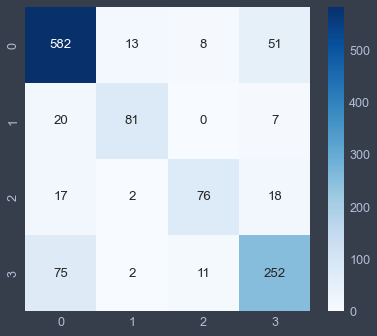

In [121]:
## TESTE COM REGRESSÃO LOGISTICA
lr = LogisticRegression()


lr.fit(X_train, y_train)                  # Emprega o conjunto de treinamento 

y_pred = lr.predict(X_test)



#Acuracidade


print(Style.BRIGHT + Fore.RED + "MATRIZ DE CONFUSAO" + Style.RESET_ALL)
print("---------------------- \n")
print(confusion_matrix(y_test, y_pred))
print("---------------------- \n")    

acuracidade_rl = accuracy_score(y_test, y_pred)
print(Style.BRIGHT + Fore.RED + "ACURACIDADE" + Style.RESET_ALL)
print("---------------------- \n")
print(acuracidade_rl)
print("---------------------- \n")    


print(Fore.BLUE +  "\n \n  RELATORIO COM MAIS INFORMACOES")
print("\n \n \n ")


f1_score_rl = f1_score(y_test, y_pred, average="macro")
precision_score_rl = precision_score(y_test, y_pred, average="macro")
recall_score_rl = recall_score(y_test, y_pred, average="macro")

print(classification_report(y_test, y_pred))
print("F1 Score : ",f1_score_rl)
print("Precision Score : ",precision_score_rl)
print("Recall Score : ",recall_score_rl)


sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')

### ------------------------------------------------------------------------------------------------

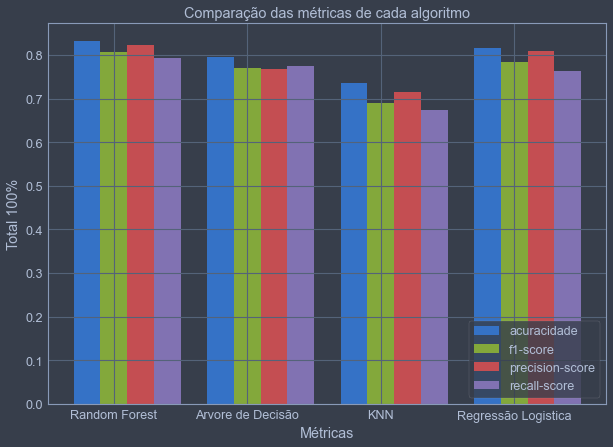

In [122]:
## Grafico Comparativo dos resultados das metricas para cada algoritmo

b =0.2
n = ["Random Forest","Arvore de Decisão","KNN","Regressão Logistica"]
acuracidade_bar = [acuracidade_rf,acuracidade_ar,acuracidade_knn,acuracidade_rl]
f1_score_bar = [f1_score_rf,f1_score_ar,f1_score_knn,f1_score_rl]
precision_score_bar = [precision_score_rf,precision_score_ar,precision_score_knn,precision_score_rl]
recall_score_bar = [recall_score_rf,recall_score_ar,recall_score_knn,recall_score_rl]

bar1 = np.arange(len(n))
bar2 = [i+b for i in bar1]
bar3 = [i+b for i in bar2]
bar4 = [i+b for i in bar3]

plt.figure(figsize = (10, 7))
plt.bar(bar1,acuracidade_bar,b,label="acuracidade")
plt.bar(bar2,f1_score_bar,b,label="f1-score")
plt.bar(bar3,precision_score_bar,b,label="precision-score")
plt.bar(bar4,recall_score_bar,b,label="recall-score")

plt.xlabel("Métricas")
plt.ylabel("Total 100%")
plt.title("Comparação das métricas de cada algoritmo")
plt.xticks(bar1+b,n)
plt.legend(loc='lower right')
plt.savefig('resultado_tf.png')  ## na iteração com bag-of-words, trocar por resultado_bag.png
plt.show()